In [1]:
!pip install rasterio

In [2]:
import os
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset,DataLoader,random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random



Dataset and Dataloader Class

In [3]:
class AlluvialBarDataset(Dataset):
  def __init__(self,img_dir,mask_dir,transform = None ):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_list = sorted(os.listdir(img_dir))
    self.mask_list = sorted(os.listdir(mask_dir))
    self.transform = transform

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir,self.img_list[idx])
    mask_path = os.path.join(self.mask_dir,self.mask_list[idx])
###########################################if in raster format###############
    # with rasterio.open(img_path) as src:
    #   img = src.read().astype(np.float32)
    # with rasterio.open(mask_path) as src:
    #   mask = src.read().astype(np.float32)

###########################################if in numpy format###############
    img = np.load(img_path)     #likely (C,H,W)
    mask = np.load(mask_path)   #likely (1,H,W)

# --- Ensure image is (H, W, C) for Albumnetations
    if img.ndim == 3 :
       img = np.transpose(img, (1, 2, 0))  # → (H, W, C)
# --- Ensure mask is (H, W) for Albumnetations by removing the singleton using squeeze
    if mask.ndim == 3:
            mask = np.squeeze(mask, axis=0)


#Resize to ensure they have same dimensions
    #Get the minimum height and width among image and mask
    min_height = min(img.shape[0], mask.shape[0])
    min_width = min(img.shape[1], mask.shape[1])

#Resize image and mask using array slicing
    img = img[:min_height, :min_width, ...]  # ... preserves other dimensions(channel) for image
    mask = mask[:min_height, :min_width]


    if self.transform :
        augmented  = self.transform(image =img,mask = mask)
        img = augmented['image']
        mask = augmented['mask']

# Convert to tensor and permute channels to first dimension and bring back the singleton using the unsqeeze function
        img = torch.tensor(img).permute(2, 0, 1)  # (C, H, W)
        mask = torch.tensor(mask).unsqueeze(0)    # (1, H, W)

    # else :
    #     img = torch.tensor(img).permute(2,0,1)
    #     mask = torch.from_numpy(mask).unsqueeze(0)



    return img,mask

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.2)
])


<ipython-input-3-451847dc4c48>:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2)


In [4]:
img_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy_normalized'
mask_dir = '/content/drive/MyDrive/FirstDeepLearningProject/label_npy'
dataset = AlluvialBarDataset(img_dir,mask_dir,transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset)- train_size


train_dataset,test_dataset = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=8,shuffle= False)

Sanity Checks

In [5]:
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
# Expected output: Image shape: (8, 256, 256)


Image shape: torch.Size([7, 256, 256]), Mask shape: torch.Size([1, 256, 256])


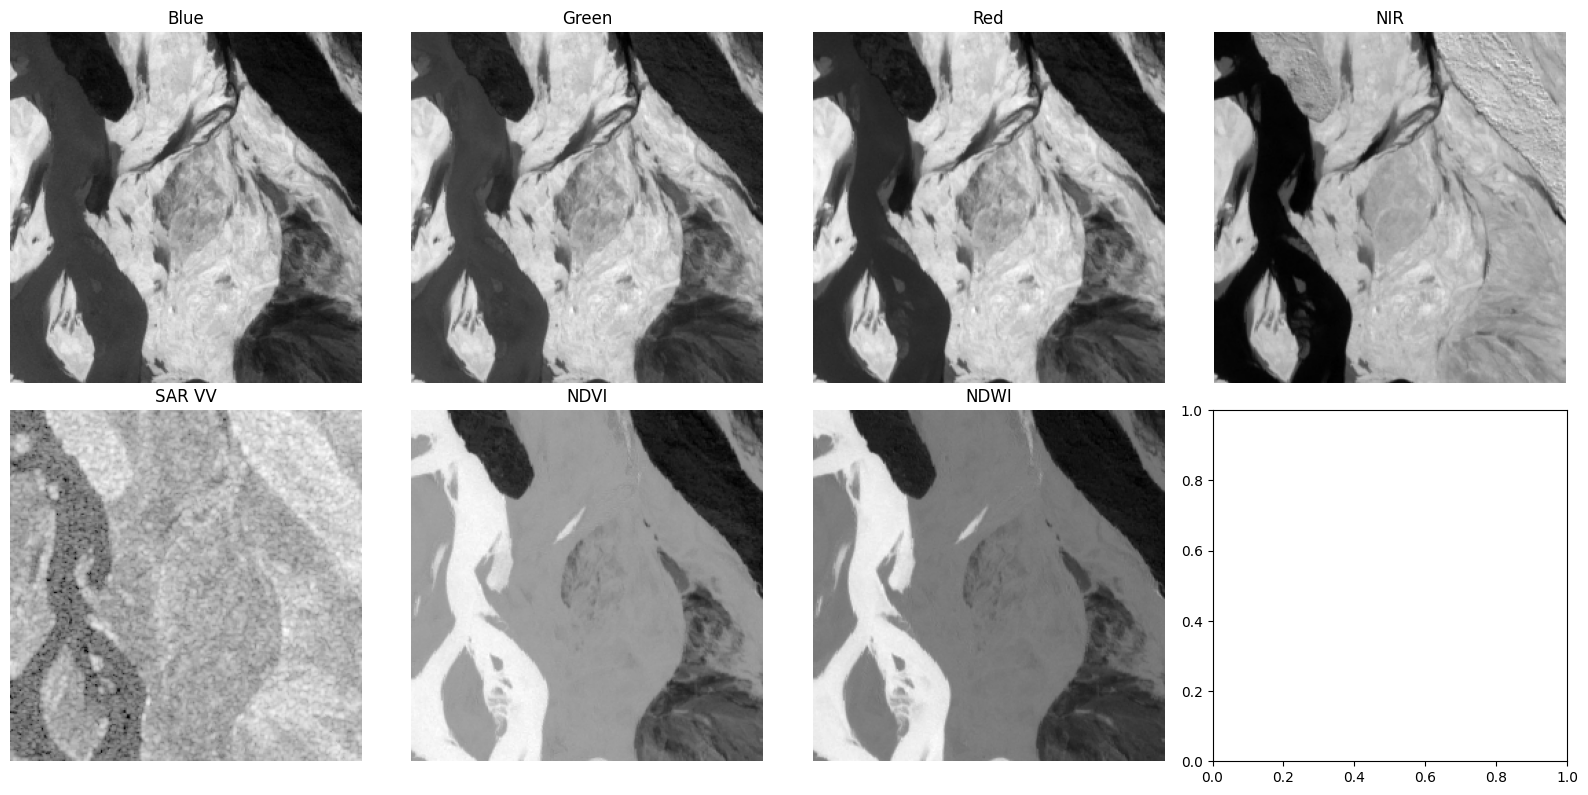

In [6]:
def visualize_bands(image):
    band_names = ['Blue', 'Green', 'Red', 'NIR', 'SAR VV','NDVI', 'NDWI']
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.ravel()

    for i in range(7):
        band = image[i].numpy()
        axs[i].imshow(band, cmap='gray')
        axs[i].set_title(band_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example
visualize_bands(dataset[100][0])


In [7]:
def check_band_stats(image):
    for i, name in enumerate( ['Blue', 'Green', 'Red', 'NIR', 'SAR VV','NDVI', 'NDWI']):
        band = image[i].numpy()
        print(f"{name:8s} → min: {band.min():.3f}, max: {band.max():.3f}, mean: {band.mean():.3f}, std: {band.std():.3f}")

# Example
check_band_stats(dataset[100][0])


Blue     → min: 2.012, max: 9.608, mean: 5.596, std: 2.195
Green    → min: 2.098, max: 10.580, mean: 6.275, std: 2.340
Red      → min: 1.694, max: 11.145, mean: 6.258, std: 2.802
NIR      → min: 0.000, max: 1.000, mean: 0.545, std: 0.268
SAR VV   → min: 0.000, max: 1.000, mean: 0.673, std: 0.127
NDVI     → min: 0.149, max: 0.692, mean: 0.459, std: 0.128
NDWI     → min: 0.199, max: 0.761, mean: 0.467, std: 0.134


In [ ]:
# for batch_imgpatch,batch_maskpatch in dataloader:
#   print(batch_imgpatch)
#   print(batch_maskpatch)
#   print("--"*100)

Streaming output truncated to the last 5000 lines.
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  8.9187e-02,  2.2800e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  3.3043e-02,  4.6981e-02,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 9.3819e-03,  2.6874e-02,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]],


        [[[ 4.0549e+00,  4.1569e+00,  3.8431e+00,  ...,  8.2118e+00,
            8.2275e+00,  8.0549e+00],
          [ 3.8431e+00,  3.9608e+00,  3.8196e+00,  ...,  8.1412e+00,
            8.0863e+00,  8.0314e+00],
          [ 3.9843e+00,  3.8078e+00,  3.8588e+00,  ...,  8.2980e+00,
            7.9843e+00,  7.9216e+00],
          ...,
          [ 3.2549e+0

Simple Trial Architecture

In [ ]:
# class SimpleSegnet(nn.Module):
#   def __init__(self,in_channels):
#    super(SimpleSegnet,self).__init__()
#    self.encoder = nn.Sequential(
#        nn.Conv2d(in_channels,16,kernel_size = 3,padding = 1),
#        nn.ReLU(),
#        nn.MaxPool2d(kernel_size = 2,stride = 2),
#        nn.Conv2d(16,32,kernel_size = 3,padding = 1),
#        nn.ReLU(),
#        nn.MaxPool2d(kernel_size = 2,stride = 2)
#    )

#    self.decoder = nn.Sequential(
#        nn.ConvTranspose2d(32,16,kernel_size = 2,stride = 2) ,
#        nn.ReLU(),
#        nn.ConvTranspose2d(16,1,kernel_size = 2,stride = 2),
#        nn.Sigmoid()
#    )

#   def forward(self,x):
#     x = self.encoder(x)
#     x = self.decoder(x)

#     return x




Architecture

In [8]:
class BarUNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[16,32,64]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        # Contracting path
        for feat in features:
            block = nn.Sequential(
                nn.Conv2d(in_channels, feat, kernel_size=3, padding=1),
                nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
                nn.Conv2d(feat, feat,   kernel_size=3, padding=1),
                nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
            )
            self.downs.append(block)
            in_channels = feat
        # Expanding path
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(feat*2, feat, kernel_size=3, padding=1),
                nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
                nn.Conv2d(feat, feat,   kernel_size=3, padding=1),
                nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
            ))
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1]*2), nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1]*2), nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2,2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        # Encoder
        for down in self.downs:
            x = down(x); skips.append(x)
            x = self.pool(x)
        # Bottleneck
        x = self.bottleneck(x)
        skips = skips[::-1]
        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)      # up-convolution
            skip = skips[idx//2]
            if x.shape != skip.shape:
                x = F.pad(x, [0, skip.shape[3]-x.shape[3], 0, skip.shape[2]-x.shape[2]])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)    # conv layers
        return self.final_conv(x)    # (N,1,H,W)


Model Parameters

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 7
out_channels = 1
model  = BarUNet(in_channels,out_channels).to(device)

# Suppose we computed pos_weight = (num_negative / num_positive)
pos_weight = torch.tensor([3.0], device=device)  # example
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

Model trainign and validation

Epoch 1, Training Loss: 0.6650
Epoch 2, Training Loss: 0.5376
Epoch 3, Training Loss: 0.5016
Epoch 4, Training Loss: 0.4688
Epoch 5, Training Loss: 0.4526
Epoch 6, Training Loss: 0.4229
Epoch 7, Training Loss: 0.4115
Epoch 8, Training Loss: 0.3526
Epoch 9, Training Loss: 0.3130
Epoch 10, Training Loss: 0.3333
Epoch 11, Training Loss: 0.3256
Epoch 12, Training Loss: 0.3289
Epoch 13, Training Loss: 0.3073
Epoch 14, Training Loss: 0.3346
Epoch 15, Training Loss: 0.3140
Epoch 16, Training Loss: 0.3325
Epoch 17, Training Loss: 0.2987
Epoch 18, Training Loss: 0.3132
Epoch 19, Training Loss: 0.3105
Epoch 20, Training Loss: 0.2797
Epoch 21, Training Loss: 0.3186
Epoch 22, Training Loss: 0.2835
Epoch 23, Training Loss: 0.3021
Epoch 24, Training Loss: 0.3455
Epoch 25, Training Loss: 0.2650
Epoch 26, Training Loss: 0.3443
Epoch 27, Training Loss: 0.2291
Epoch 28, Training Loss: 0.3350
Epoch 29, Training Loss: 0.3425
Epoch 30, Training Loss: 0.2528
Epoch 31, Training Loss: 0.3202
Epoch 32, Trainin

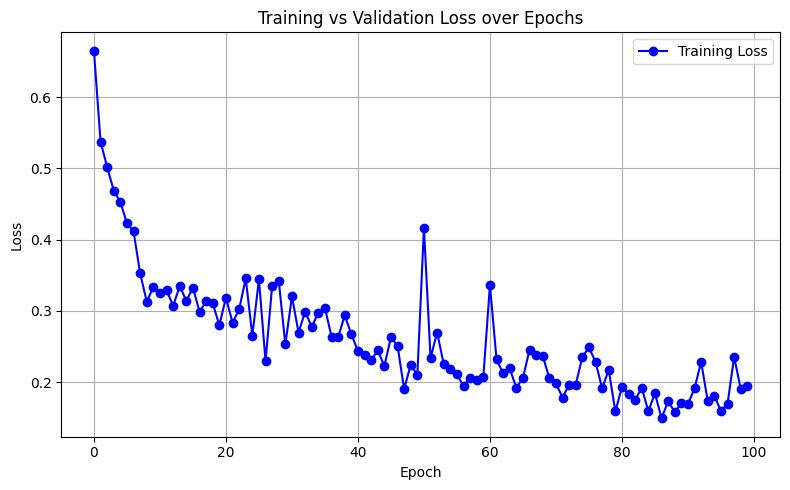

In [10]:
train_losses = []
val_losses = []
for epoch in range(100):
    model.train()
    running_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device).float()
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1, Validation Loss: 0.1957
Epoch 2, Validation Loss: 0.1705
Epoch 3, Validation Loss: 0.1940
Epoch 4, Validation Loss: 0.1738
Epoch 5, Validation Loss: 0.2040
Epoch 6, Validation Loss: 0.1714
Epoch 7, Validation Loss: 0.1428
Epoch 8, Validation Loss: 0.1607
Epoch 9, Validation Loss: 0.1624
Epoch 10, Validation Loss: 0.1704
Epoch 11, Validation Loss: 0.2002
Epoch 12, Validation Loss: 0.1806
Epoch 13, Validation Loss: 0.1590
Epoch 14, Validation Loss: 0.1972
Epoch 15, Validation Loss: 0.1806
Epoch 16, Validation Loss: 0.1485
Epoch 17, Validation Loss: 0.1925
Epoch 18, Validation Loss: 0.1917
Epoch 19, Validation Loss: 0.1804
Epoch 20, Validation Loss: 0.1797
Epoch 21, Validation Loss: 0.1777
Epoch 22, Validation Loss: 0.1548
Epoch 23, Validation Loss: 0.1391
Epoch 24, Validation Loss: 0.1576
Epoch 25, Validation Loss: 0.1676
Epoch 26, Validation Loss: 0.2015
Epoch 27, Validation Loss: 0.1567
Epoch 28, Validation Loss: 0.1574
Epoch 29, Validation Loss: 0.1564
Epoch 30, Validation Lo

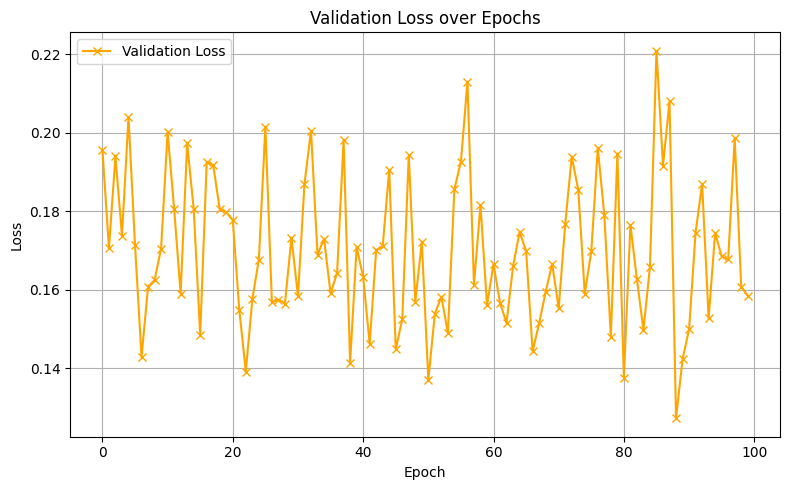

In [11]:
val_losses = []

for epoch in range(100):  # fixed variable name here
    model.eval()
    val_running_loss = 0
    all_preds, all_truths = [], []  # move inside epoch loop

    with torch.no_grad():
        for val_imgs, val_masks in test_loader:
            val_imgs, val_masks = val_imgs.to(device), val_masks.to(device).float()
            output = model(val_imgs)
            val_loss = criterion(output, val_masks)
            val_running_loss += val_loss.item()

            val_preds = (torch.sigmoid(output) > 0.5).int()

            all_preds.append(val_preds.cpu().numpy().flatten())
            all_truths.append(val_masks.cpu().numpy().flatten())

    # Move these outside the batch loop but inside epoch
    all_preds = np.concatenate(all_preds)
    all_truths = np.concatenate(all_truths)

    # Compute validation loss for the epoch
    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}")

# After training, plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Epoch 1, Training Loss: 0.5226
Epoch 1, Validation Loss: 0.8860
Epoch 2, Training Loss: 0.4579
Epoch 2, Validation Loss: 0.3867
Epoch 3, Training Loss: 0.4708
Epoch 3, Validation Loss: 0.4918
Epoch 4, Training Loss: 0.3965
Epoch 4, Validation Loss: 0.3360
Epoch 5, Training Loss: 0.4159
Epoch 5, Validation Loss: 0.3274
Epoch 6, Training Loss: 0.3847
Epoch 6, Validation Loss: 0.6007
Epoch 7, Training Loss: 0.3462
Epoch 7, Validation Loss: 0.3523
Epoch 8, Training Loss: 0.3207
Epoch 8, Validation Loss: 0.7435
Epoch 9, Training Loss: 0.3196
Epoch 9, Validation Loss: 0.3549
Epoch 10, Training Loss: 0.3502
Epoch 10, Validation Loss: 0.2856
Epoch 11, Training Loss: 0.3416
Epoch 11, Validation Loss: 0.3028
Epoch 12, Training Loss: 0.3203
Epoch 12, Validation Loss: 0.2528
Epoch 13, Training Loss: 0.4577
Epoch 13, Validation Loss: 0.3494
Epoch 14, Training Loss: 0.3443
Epoch 14, Validation Loss: 0.2409
Epoch 15, Training Loss: 0.3660
Epoch 15, Validation Loss: 0.2601
Epoch 16, Training Loss: 0.3

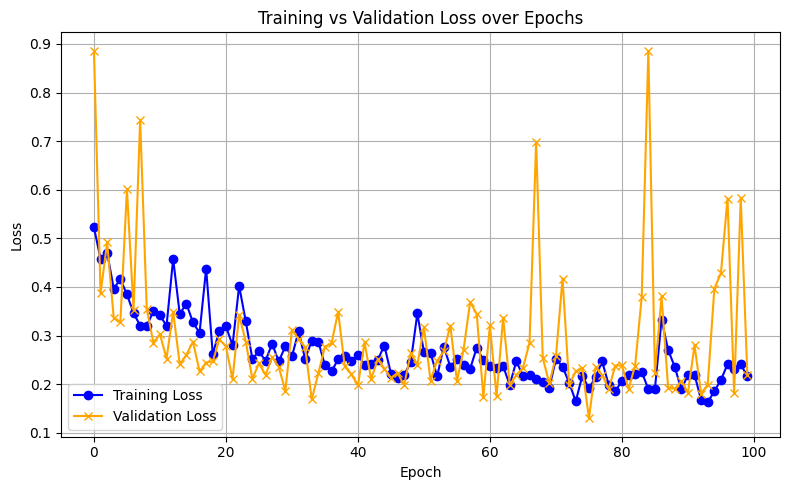

In [ ]:


    # # Validation loss calculation
    # model.eval()
    # val_running_loss = 0
    # with torch.no_grad():
    #     for val_imgs, val_masks in test_loader:
    #         val_imgs, val_masks = val_imgs.to(device), val_masks.to(device).float()
    #         output = model(val_imgs)
    #         val_preds = (torch.sigmoid(output) > 0.5).int()
    #         val_loss = criterion(output, val_masks)
    #         val_running_loss += val_loss.item()

    # epoch_val_loss = val_running_loss / len(test_loader)
    # val_losses.append(epoch_val_loss)
    # print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}")





In [12]:
# model.eval()
# TP=TN=FP=FN=0
# with torch.no_grad():
#     for images, masks in test_loader:
#         images = images.to(device)
#         masks  = masks.to(device).unsqueeze(1)
#         outputs = model(images)               # logits
#         preds = (torch.sigmoid(outputs) > 0.5).int()
#         masks_i = masks.int()
#         TP += ((preds==1) & (masks_i==1)).sum().item()
#         TN += ((preds==0) & (masks_i==0)).sum().item()
#         FP += ((preds==1) & (masks_i==0)).sum().item()
#         FN += ((preds==0) & (masks_i==1)).sum().item()

# acc  = (TP+TN) / (TP+TN+FP+FN) if (TP+TN+FP+FN)>0 else 0
# precision = TP / (TP+FP)            if (TP+FP)>0 else 0
# recall    = TP / (TP+FN)            if (TP+FN)>0 else 0
# iou       = TP / (TP+FP+FN)         if (TP+FP+FN)>0 else 0

# with torch.no_grad():
#   all_preds,all_masks = [],[]
#   for imgs,masks in test_loader:
#     imgs = imgs.to(device)
#     preds = model(imgs)

#     pred_bin = (preds >0.5).int().cpu().numpy()
#     masks = masks.cpu().numpy()
#     all_preds.append(pred_bin.flatten())
#     all_masks.append(masks.flatten())

#   all_preds = np.concatenate(all_preds)
#   all_masks = np.concatenate(all_masks)

#   acc = accuracy_score(all_masks,all_preds)
#   precision = precision_score(all_masks,all_preds)
#   recall = recall_score(all_masks,all_preds)
#   iou = jaccard_score(all_masks,all_preds)

# print(f"\n📊 Evaluation:\nAccuracy: {acc:.4f}, IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


# Metric functions
def compute_iou(pred, truth):
    intersection = np.logical_and(pred, truth).sum()
    union = np.logical_or(pred, truth).sum()
    return intersection / union if union != 0 else 0

def precision(pred, truth):
    tp = np.logical_and(pred == 1, truth == 1).sum()
    fp = np.logical_and(pred == 1, truth == 0).sum()
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(pred, truth):
    tp = np.logical_and(pred == 1, truth == 1).sum()
    fn = np.logical_and(pred == 0, truth == 1).sum()
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def accuracy(pred, truth):
    return (pred == truth).sum() / pred.size

# Compute metrics
iou = compute_iou(all_preds, all_truths)
pres = precision(all_preds, all_truths)
rec = recall(all_preds, all_truths)
acc = accuracy(all_preds, all_truths)

print(f"\n📊 Evaluation:\nAccuracy: {acc:.4f}, IoU: {iou:.4f}, Precision: {pres:.4f}, Recall: {rec:.4f}")





📊 Evaluation:
Accuracy: 0.9445, IoU: 0.7646, Precision: 0.7769, Recall: 0.9798


In [13]:
def visualize_predictions(model, dataset, num_samples=3, rgb_indices=(1,2,0)):
    model.eval()
    idxs = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12,4*num_samples))

    for i, idx in enumerate(idxs):
        image, mask = dataset[idx]  # image:(8,H,W), mask:(H,W)

        # Select correct RGB bands
        img3 = image[list(rgb_indices)].numpy()
        img3 = np.clip(img3, a_min=np.percentile(img3, 1), a_max=np.percentile(img3, 99))
        img3 = (img3 - img3.min()) / (img3.max() - img3.min() + 1e-6)

        # Predict
        with torch.no_grad():
            pred = torch.sigmoid(model(image.unsqueeze(0).to(device)))
            pred = (pred.squeeze().cpu().numpy() > 0.5)

        # Display
        axes[i,0].imshow(np.transpose(img3, (1,2,0)))
        axes[i,0].set_title("Input RGB Bands")
        axes[i,1].imshow(mask.squeeze(), cmap='gray')
        axes[i,1].set_title("Ground Truth")
        axes[i,2].imshow(pred, cmap='gray')
        axes[i,2].set_title("Prediction")

    plt.tight_layout()
    plt.show()


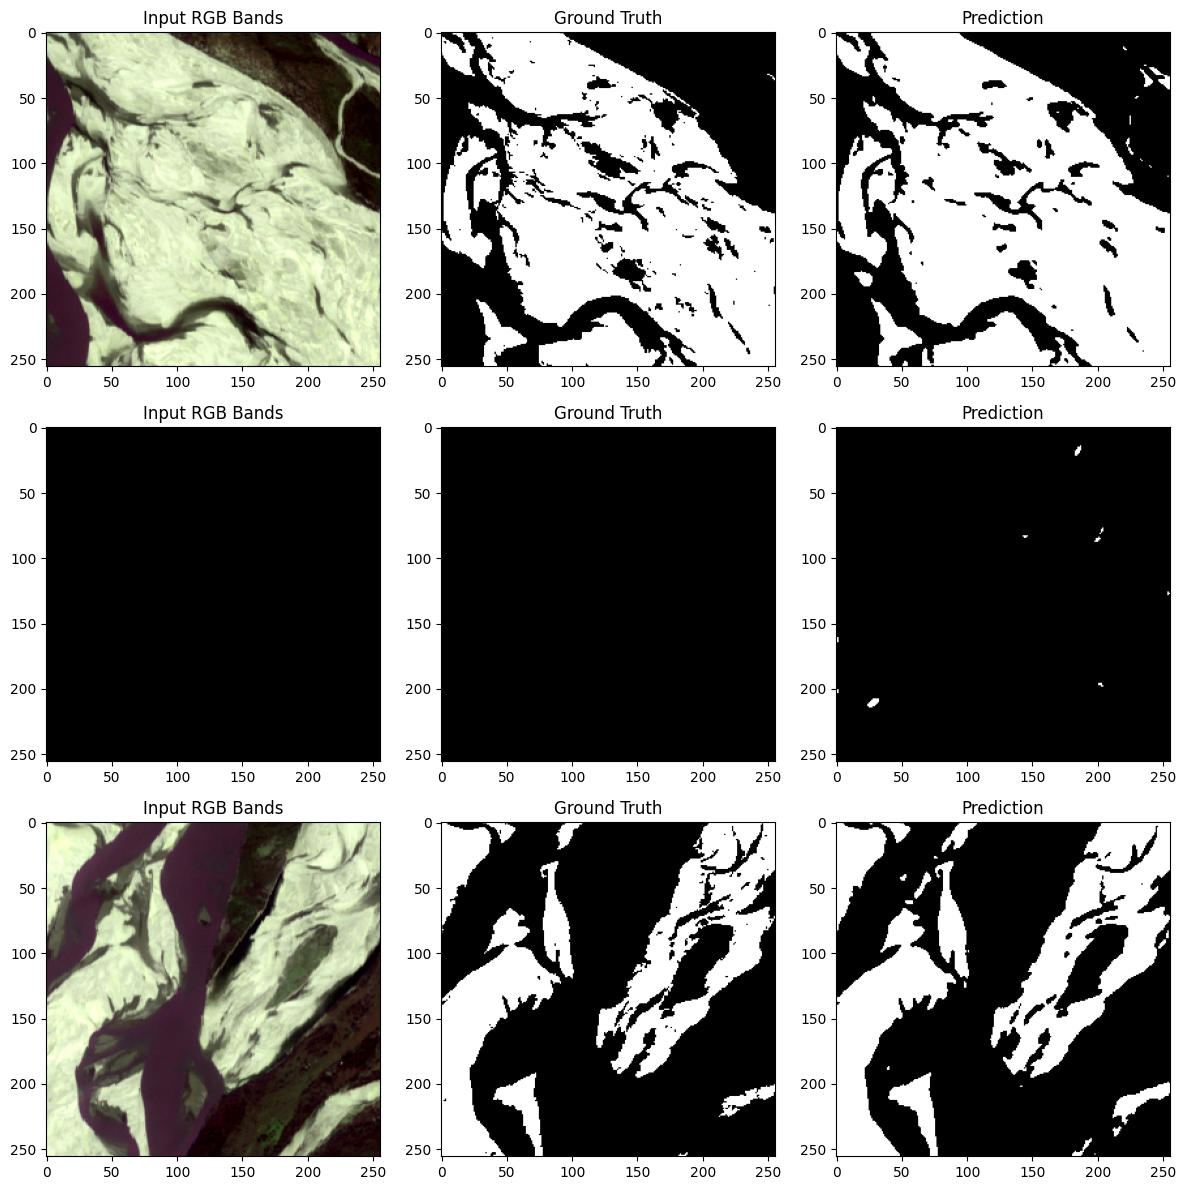

In [21]:
# Example usage (after training):
visualize_predictions(model, test_dataset, num_samples=3)